EUR/GBP daily series: 5262 rows | 2005-09-16 → 2025-11-16

Best baseline alpha/beta on grid:
 alpha  beta  n_trades  hit_rate  total_logret  avg_hold
  0.02  0.14      45.0  0.333333      0.174562 62.777778

Best LONG-only alpha/beta on grid: 0.01 0.2399999999999999 | long_n: 18.0 | total_long: 0.2254720989296463
Best SHORT-only alpha/beta on grid: 0.060000000000000005 0.2699999999999999 | short_n: 25.0 | total_short: 0.004037324684851248

Deceleration exit sweep (baseline a/b):
 gamma_mult  n_trades  hit_rate  total_logret  avg_logret  avg_hold
        2.0        69  0.434783      0.053720    0.000779 17.971014
        1.0        90  0.388889      0.044594    0.000495  4.644444
        0.0        92  0.510870      0.042098    0.000458  1.652174
        0.5        92  0.434783      0.001456    0.000016  2.456522
        1.5        79  0.430380     -0.009982   -0.000126 10.594937
        3.0        50  0.280000     -0.044986   -0.000900 46.100000
Best gamma_mult: 2.0 | {'n_trades': 69, 

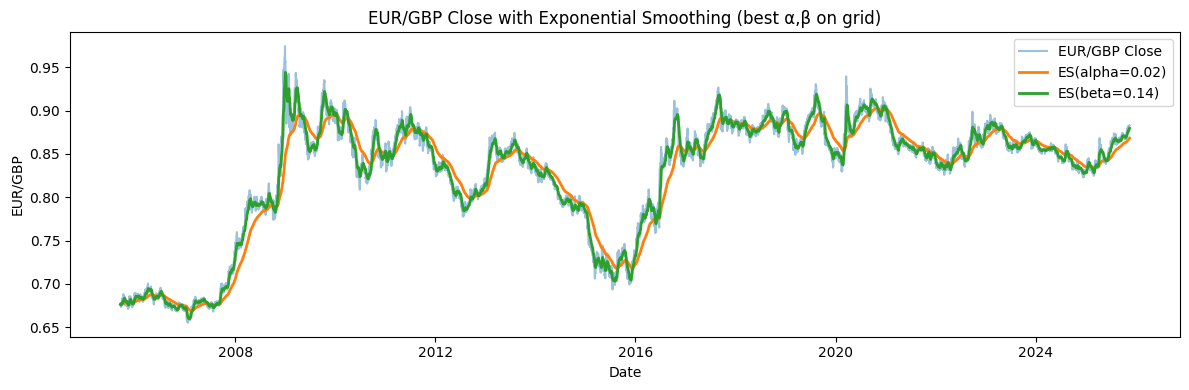

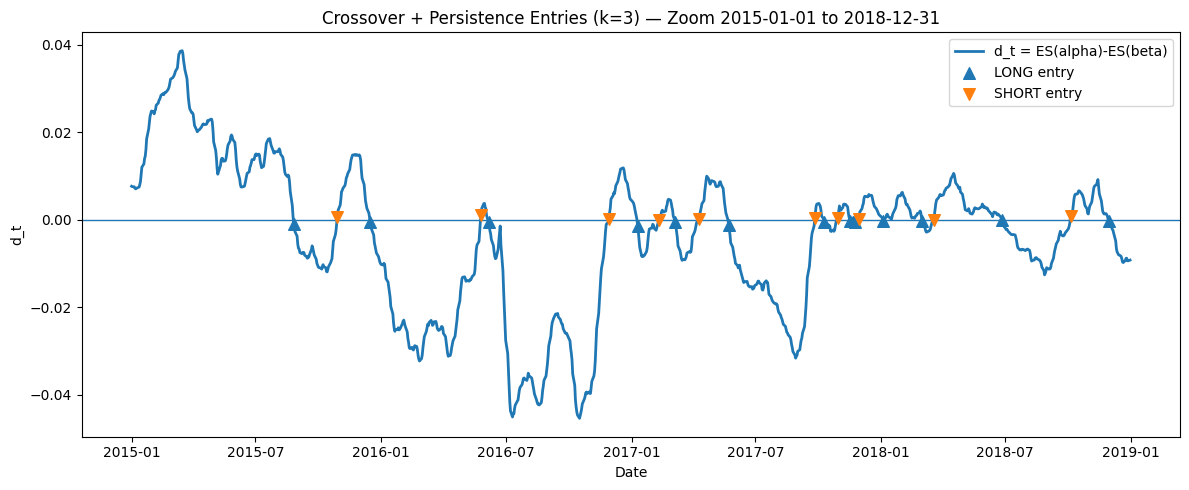

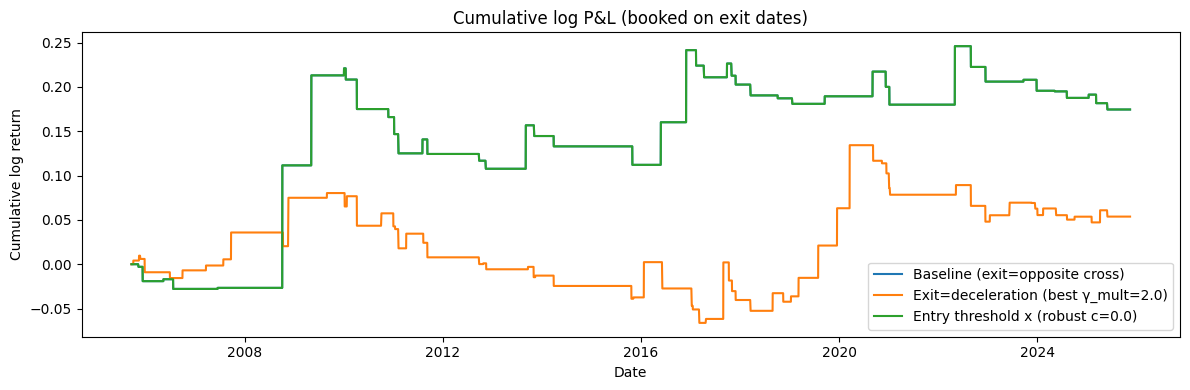


--- FINAL NUMBERS (from final_clean_FX_data.csv) ---
Best baseline α,β: 0.02 0.13999999999999996 | k = 3
Baseline stats: {'n_trades': 45, 'hit_rate': 0.3333333333333333, 'total_logret': 0.17456171060169445, 'avg_logret': 0.003879149124482099, 'avg_hold': 62.77777777777778} | simple total ≈ 19.07 %
Baseline side breakdown: {'long_n': 33, 'long_hit': 0.36363636363636365, 'long_total': 0.21734502897436922, 'short_n': 12, 'short_hit': 0.25, 'short_total': -0.042783318372674795}
Best LONG-only α,β: 0.01 0.2399999999999999 | total_long: 0.2254720989296463 | long_n: 18.0
Best SHORT-only α,β: 0.060000000000000005 0.2699999999999999 | total_short: 0.004037324684851248 | short_n: 25.0
Best deceleration γ_mult: 2.0 | stats: {'n_trades': 69, 'hit_rate': 0.43478260869565216, 'total_logret': 0.05371998326273873, 'avg_logret': 0.0007785504820686773, 'avg_hold': 17.971014492753625} | simple total ≈ 5.52 %
Robust threshold c: 0.0 | stats: {'n_trades': 45, 'hit_rate': 0.3333333333333333, 'total_logret'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 0) Load data
df = pd.read_csv("final_clean_FX_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").drop_duplicates("Date")

# Use daily close as the EUR/GBP price series
S = df.set_index("Date")["Close"].astype(float)
dates = S.index
px = S.values

print("EUR/GBP daily series:", len(S), "rows |", dates.min().date(), "→", dates.max().date())

# 1) Exponential Smoothing
# ES_t = alpha*S_t + (1-alpha)*ES_{t-1}, ES_0 = S_0

def ES_vals(series: pd.Series, alpha: float) -> np.ndarray:
    # adjust=False matches recursive ES exactly
    return series.ewm(alpha=alpha, adjust=False).mean().values


# 2) Crossover + persistence logic (k days)
# d_t = ES(alpha) - ES(beta)
# Long:  d crosses +→- AND previous k days d>0
# Short: d crosses -→+ AND previous k days d<0
# Optional threshold x: require d_t < -x_t (long) or d_t > x_t (short)

def entries_np(d: np.ndarray, k: int = 3, x: np.ndarray | None = None):
    n = len(d)
    if x is None:
        x = np.zeros(n, dtype=float)

    # persistence for k=3 (fast and exact)
    pers_pos = np.zeros(n, dtype=bool)
    pers_neg = np.zeros(n, dtype=bool)
    if k == 1:
        pers_pos[:] = True
        pers_neg[:] = True
    elif k == 2:
        pers_pos[2:] = (d[1:-1] > 0) & (d[0:-2] > 0)
        pers_neg[2:] = (d[1:-1] < 0) & (d[0:-2] < 0)
    else:  # k>=3
        pers_pos[3:] = (d[2:-1] > 0) & (d[1:-2] > 0) & (d[0:-3] > 0)
        pers_neg[3:] = (d[2:-1] < 0) & (d[1:-2] < 0) & (d[0:-3] < 0)

    cross_down = np.zeros(n, dtype=bool)
    cross_up   = np.zeros(n, dtype=bool)
    cross_down[1:] = (d[:-1] > 0) & (d[1:] < -x[1:])  # + → -
    cross_up[1:]   = (d[:-1] < 0) & (d[1:] >  x[1:])  # - → +

    long_e  = cross_down & pers_pos
    short_e = cross_up   & pers_neg
    return long_e, short_e

# 3) Backtest (enter/exit on close of signal day), log returns

def backtest_np(px: np.ndarray, dates: pd.DatetimeIndex,
                long_e: np.ndarray, short_e: np.ndarray,
                exit_mode: str = "opposite",
                decel: np.ndarray | None = None,
                gamma: np.ndarray | None = None,
                cost_rt_bps: float = 0.0):
    pos = 0
    entry_i = -1
    entry_px = 0.0
    trades = []
    cost = cost_rt_bps / 10000.0

    for t in range(1, len(px)):
        if pos == 0:
            if long_e[t]:
                pos = 1; entry_i = t; entry_px = px[t]
            elif short_e[t]:
                pos = -1; entry_i = t; entry_px = px[t]
        else:
            exit_now = False
            if exit_mode == "opposite":
                exit_now = (pos == 1 and short_e[t]) or (pos == -1 and long_e[t])
            elif exit_mode == "deceleration":
                if decel is not None and gamma is not None:
                    if pos == 1 and decel[t] < -gamma[t]: exit_now = True
                    if pos == -1 and decel[t] >  gamma[t]: exit_now = True
                # safety: exit on opposite signal too
                if (pos == 1 and short_e[t]) or (pos == -1 and long_e[t]):
                    exit_now = True

            if exit_now:
                lr = float(np.log(px[t] / entry_px) * pos - cost)
                trades.append((dates[entry_i], dates[t], pos, entry_px, px[t], lr, t-entry_i))
                pos = 0

    return pd.DataFrame(trades, columns=["entry","exit","side","entry_px","exit_px","logret_net","hold_days_trading"])

def summarize(tr: pd.DataFrame):
    if tr.empty:
        return {"n_trades":0,"hit_rate":np.nan,"total_logret":0.0,"avg_logret":np.nan,"avg_hold":np.nan}
    return {
        "n_trades": int(len(tr)),
        "hit_rate": float((tr.logret_net > 0).mean()),
        "total_logret": float(tr.logret_net.sum()),
        "avg_logret": float(tr.logret_net.mean()),
        "avg_hold": float(tr.hold_days_trading.mean()),
    }

def side_breakdown(tr: pd.DataFrame):
    L = tr[tr.side==1]
    Sh = tr[tr.side==-1]
    return {
        "long_n": int(len(L)),
        "long_hit": float((L.logret_net>0).mean()) if len(L) else np.nan,
        "long_total": float(L.logret_net.sum()) if len(L) else np.nan,
        "short_n": int(len(Sh)),
        "short_hit": float((Sh.logret_net>0).mean()) if len(Sh) else np.nan,
        "short_total": float(Sh.logret_net.sum()) if len(Sh) else np.nan,
    }

def equity_curve(tr: pd.DataFrame, index: pd.DatetimeIndex):
    pnl = pd.Series(0.0, index=index)
    for _, r in tr.iterrows():
        pnl.loc[pd.to_datetime(r["exit"])] += r["logret_net"]
    return pnl.cumsum()

def simple_total(logret): 
    return float(np.exp(logret) - 1)


# 4) Choose k (persistence) + search best alpha/beta on a practical grid

k = 3

alphas = np.arange(0.01, 0.11, 0.01)   # 0.01..0.10
betas  = np.arange(0.06, 0.31, 0.01)   # 0.06..0.30

uniq = np.unique(np.concatenate([alphas, betas]))
es_cache = {float(a): ES_vals(S, float(a)) for a in uniq}

rows = []
for a in alphas:
    ea = es_cache[float(a)]
    for b in betas:
        if b <= a: 
            continue
        d = ea - es_cache[float(b)]
        le, se = entries_np(d, k=k)
        tr = backtest_np(px, dates, le, se, exit_mode="opposite")
        st = summarize(tr)
        rows.append({"alpha":float(a),"beta":float(b), **st})

res = pd.DataFrame(rows).sort_values(["total_logret","hit_rate"], ascending=[False, False])
best = res.iloc[0].to_dict()
best_a, best_b = best["alpha"], best["beta"]

print("\nBest baseline alpha/beta on grid:")
print(pd.DataFrame([best])[["alpha","beta","n_trades","hit_rate","total_logret","avg_hold"]].to_string(index=False))

# Baseline trades for best a/b
ESa = es_cache[best_a]
ESb = es_cache[best_b]
d_best = ESa - ESb
le0, se0 = entries_np(d_best, k=k)

tr_base = backtest_np(px, dates, le0, se0, exit_mode="opposite")
st_base = summarize(tr_base)
sb_base = side_breakdown(tr_base)


# 5) Long-only vs Short-only best params 

def total_side(tr, side):
    sub = tr[tr.side==side]
    return float(sub.logret_net.sum()) if len(sub) else -np.inf

rows2 = []
for a in alphas:
    ea = es_cache[float(a)]
    for b in betas:
        if b <= a: 
            continue
        d = ea - es_cache[float(b)]
        le, se = entries_np(d, k=k)
        tr = backtest_np(px, dates, le, se, exit_mode="opposite")
        if tr.empty:
            continue
        rows2.append({
            "alpha":float(a),"beta":float(b),
            "total_all": float(tr.logret_net.sum()),
            "total_long": total_side(tr, 1),
            "total_short": total_side(tr, -1),
            "long_n": int((tr.side==1).sum()),
            "short_n": int((tr.side==-1).sum()),
            "hit_rate": float((tr.logret_net>0).mean())
        })

grid2 = pd.DataFrame(rows2)
best_long  = grid2.sort_values("total_long", ascending=False).iloc[0].to_dict()
best_short = grid2.sort_values("total_short", ascending=False).iloc[0].to_dict()

print("\nBest LONG-only alpha/beta on grid:", best_long["alpha"], best_long["beta"],
      "| long_n:", best_long["long_n"], "| total_long:", best_long["total_long"])
print("Best SHORT-only alpha/beta on grid:", best_short["alpha"], best_short["beta"],
      "| short_n:", best_short["short_n"], "| total_short:", best_short["total_short"])


# 6) Exit variant: ES(beta) deceleration with gamma_mult sweep

slope = np.diff(ESb, prepend=ESb[0])
decel = np.diff(slope, prepend=slope[0])
decel_std = pd.Series(decel, index=dates).rolling(60, min_periods=60).std().fillna(0.0).values

gamma_mult_list = [0.0,0.5,1.0,1.5,2.0,3.0]
rows = []
for gm in gamma_mult_list:
    gamma = gm * decel_std
    tr = backtest_np(px, dates, le0, se0, exit_mode="deceleration", decel=decel, gamma=gamma)
    st = summarize(tr)
    rows.append({"gamma_mult":gm, **st})
decel_tbl = pd.DataFrame(rows).sort_values(["total_logret","hit_rate"], ascending=[False, False])
best_gm = float(decel_tbl.iloc[0]["gamma_mult"])

tr_decel = backtest_np(px, dates, le0, se0, exit_mode="deceleration", decel=decel, gamma=best_gm*decel_std)
st_decel = summarize(tr_decel)

print("\nDeceleration exit sweep (baseline a/b):")
print(decel_tbl.to_string(index=False))
print("Best gamma_mult:", best_gm, "|", st_decel)


# 7) Threshold-x sweep: x_t = c * rolling_std_60(d)
# Robust pick requires >= 20 trades

d_std = pd.Series(d_best, index=dates).rolling(60, min_periods=60).std().fillna(0.0).values
c_list = [0.0,0.10,0.20,0.25,0.30,0.50,0.75,1.0,1.5,2.0]

rows = []
for c in c_list:
    x = c * d_std
    le, se = entries_np(d_best, k=k, x=x)
    tr = backtest_np(px, dates, le, se, exit_mode="opposite")
    st = summarize(tr)
    rows.append({"c":c, **st})
x_tbl = pd.DataFrame(rows).sort_values(["total_logret","hit_rate"], ascending=[False, False])

x_tbl_robust = x_tbl[x_tbl.n_trades >= 20].sort_values(["total_logret","hit_rate"], ascending=[False, False])
best_c = float(x_tbl_robust.iloc[0]["c"]) if len(x_tbl_robust) else 0.0

x_best = best_c * d_std
le_x, se_x = entries_np(d_best, k=k, x=x_best)
tr_x = backtest_np(px, dates, le_x, se_x, exit_mode="opposite")
st_x = summarize(tr_x)

print("\nThreshold x sweep (baseline a/b):")
print(x_tbl.to_string(index=False))
print("Robust best c (>=20 trades):", best_c, "|", st_x)


# 8) Charts

# Chart 1: Price + ES
plt.figure(figsize=(12,4))
plt.plot(dates, px, label="EUR/GBP Close", alpha=0.45)
plt.plot(dates, ESa, label=f"ES(alpha={best_a:.2f})", linewidth=2)
plt.plot(dates, ESb, label=f"ES(beta={best_b:.2f})", linewidth=2)
plt.title("EUR/GBP Close with Exponential Smoothing (best α,β on grid)")
plt.xlabel("Date"); plt.ylabel("EUR/GBP"); plt.legend(); plt.tight_layout(); plt.show()

# Chart 2: d_t with entry markers
zoom_start, zoom_end = "2015-01-01", "2018-12-31"
mask = (dates >= zoom_start) & (dates <= zoom_end)
z_dates = dates[mask]
z_d = d_best[mask]
z_le = le0[mask]; z_se = se0[mask]

plt.figure(figsize=(12,5))
plt.plot(z_dates, z_d, linewidth=2, label="d_t = ES(alpha)-ES(beta)")
plt.axhline(0, linewidth=1)
plt.scatter(z_dates[z_le], z_d[z_le], marker="^", s=70, label="LONG entry", zorder=5)
plt.scatter(z_dates[z_se], z_d[z_se], marker="v", s=70, label="SHORT entry", zorder=5)
plt.title(f"Crossover + Persistence Entries (k={k}) — Zoom {zoom_start} to {zoom_end}")
plt.xlabel("Date"); plt.ylabel("d_t"); plt.legend(); plt.tight_layout(); plt.show()

# Chart 3: equity curves
eq_base = equity_curve(tr_base, dates)
eq_de   = equity_curve(tr_decel, dates)
eq_xc   = equity_curve(tr_x, dates)

plt.figure(figsize=(12,4))
plt.plot(eq_base.index, eq_base.values, label="Baseline (exit=opposite cross)")
plt.plot(eq_de.index,   eq_de.values,   label=f"Exit=deceleration (best γ_mult={best_gm})")
plt.plot(eq_xc.index,   eq_xc.values,   label=f"Entry threshold x (robust c={best_c})")
plt.title("Cumulative log P&L (booked on exit dates)")
plt.xlabel("Date"); plt.ylabel("Cumulative log return"); plt.legend(); plt.tight_layout(); plt.show()


# 9) Final numbers 

print("\n--- FINAL NUMBERS (from final_clean_FX_data.csv) ---")
print("Best baseline α,β:", best_a, best_b, "| k =", k)
print("Baseline stats:", st_base, "| simple total ≈", round(simple_total(st_base['total_logret'])*100,2), "%")
print("Baseline side breakdown:", sb_base)
print("Best LONG-only α,β:", best_long["alpha"], best_long["beta"], "| total_long:", best_long["total_long"], "| long_n:", best_long["long_n"])
print("Best SHORT-only α,β:", best_short["alpha"], best_short["beta"], "| total_short:", best_short["total_short"], "| short_n:", best_short["short_n"])
print("Best deceleration γ_mult:", best_gm, "| stats:", st_decel, "| simple total ≈", round(simple_total(st_decel['total_logret'])*100,2), "%")
print("Robust threshold c:", best_c, "| stats:", st_x, "| simple total ≈", round(simple_total(st_x['total_logret'])*100,2), "%")


EXTENSION: Macroeconomic Variable Analysis

Raw Macroeconomic Data Summary:
              UK_GDP      EURO_GDP  EURO_Balance_Payments  \
count    5262.000000  5.262000e+03            3338.000000   
mean   508750.793044  2.561722e+06           22920.178609   
std    113175.548445  1.676636e+05           12357.534553   
min    353424.000000  2.310122e+06          -24914.235000   
25%    408599.000000  2.421947e+06           16796.909000   
50%    482690.000000  2.505032e+06           24049.704000   
75%    567451.000000  2.704010e+06           31421.093000   
max    754397.000000  2.879257e+06           50152.339000   

       GBP_Balance_Payments  GBP_trade_balance  EUR_trade_balance  
count           5262.000000        5262.000000        5262.000000  
mean          -16172.224439       -1912.261117       15657.623983  
std             8642.280031        1743.561148       40667.981892  
min           -36480.000000       -8065.000000      -23287.200000  
25%           -20413.000000       

C:\Users\mattp\AppData\Local\Temp\ipykernel_44744\3804514934.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if long_entry[t]:
C:\Users\mattp\AppData\Local\Temp\ipykernel_44744\3804514934.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif short_entry[t]:



Macro Momentum Filter Results:
  Trades: 32
  Hit Rate: 28.12%
  Total Return: 2.70%
  Avg Hold: 62.7 days

EXTENSION RESULTS COMPARISON

Strategy                         Trades   Hit Rate     Return   Avg Hold
----------------------------------------------------------------------
Baseline (no macro)                  45      33.3%     19.07%       62.8
GDP Growth Filter                    39      23.1%    -13.03%       53.8
Trade Balance Filter                 32      28.1%    -14.67%       59.8
Balance of Payments Filter           22      31.8%     14.51%       75.5
Combined Filter (all 3)               4      50.0%     -1.48%       66.8
Macro Momentum                       32      28.1%      2.70%       62.7


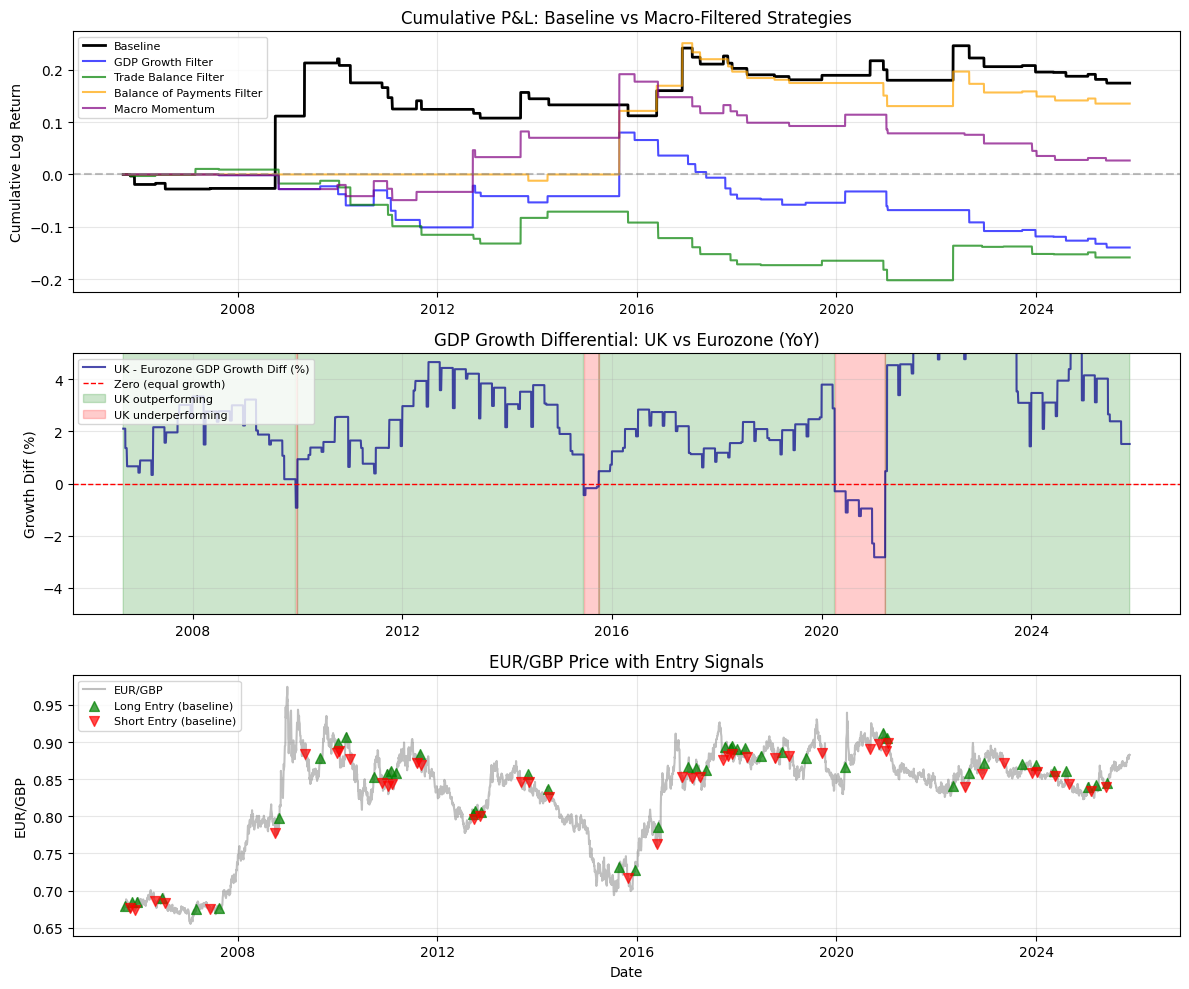


EXTENSION ANALYSIS: CONCLUSIONS

MACROECONOMIC EXTENSIONS SUMMARY

This analysis tested whether incorporating macroeconomic variables (GDP, trade 
balance, balance of payments) could improve the exponential smoothing trading 
strategy for EUR/GBP.

ECONOMIC HYPOTHESIS:
- UK fundamentals outperforming → GBP strengthens → EUR/GBP falls → favor SHORT
- UK fundamentals underperforming → GBP weakens → EUR/GBP rises → favor LONG

EXTENSIONS TESTED:

1. GDP GROWTH DIFFERENTIAL FILTER
   Used year-over-year GDP growth rates (not levels) to identify which economy
   is growing faster. Filtered long signals to UK underperformance periods,
   short signals to UK outperformance periods.
   Result: 39 trades, -13.03% return

2. TRADE BALANCE DIFFERENTIAL FILTER
   Used relative trade balance position. Countries with trade surpluses tend
   to see currency appreciation due to export demand for their currency.
   Result: 32 trades, -14.67% return

3. BALANCE OF PAYMENTS DIFFERENTIAL FILTER
   Used r

In [2]:
# =============================================================================
# 10) EXTENSIONS: Incorporating Macroeconomic Variables
# =============================================================================
# Project requirement: "You may incorporate macroeconomic variables such as:
# - Balance of payments
# - GDP  
# - Trade balance
# This allows the trading levels or strategy parameters to depend on these 
# relative indicators."
#
# ECONOMIC RATIONALE FOR EUR/GBP:
# ================================
# EUR/GBP = price of 1 EUR in GBP (how many pounds per euro)
# - EUR/GBP rises → EUR strengthening / GBP weakening
# - EUR/GBP falls → EUR weakening / GBP strengthening
#
# Long EUR/GBP = buy EUR, sell GBP = profit if GBP weakens
# Short EUR/GBP = sell EUR, buy GBP = profit if GBP strengthens
#
# Fundamental drivers of GBP strength:
# 1. Higher UK GDP GROWTH (relative to Eurozone) → attracts investment → GBP strengthens
# 2. Better UK trade balance → more demand for GBP → GBP strengthens
# 3. Better UK balance of payments → capital inflows → GBP strengthens
#
# Therefore:
# - UK outperforming → GBP strengthens → EUR/GBP falls → favor SHORT
# - UK underperforming → GBP weakens → EUR/GBP rises → favor LONG

print("="*70)
print("EXTENSION: Macroeconomic Variable Analysis")
print("="*70)

# =============================================================================
# Load and prepare macroeconomic data
# =============================================================================
df_macro = df.set_index("Date")[["UK_GDP", "EURO_GDP", "EURO_Balance_Payments", 
                                  "GBP_Balance_Payments", "GBP_trade_balance", 
                                  "EUR_trade_balance"]].copy()

print("\nRaw Macroeconomic Data Summary:")
print(df_macro.describe())
print("\nMissing values:")
print(df_macro.isnull().sum())

# Forward fill quarterly data to daily frequency
df_macro = df_macro.ffill()

# =============================================================================
# Create economically meaningful indicators
# =============================================================================

# 1. GDP GROWTH differential (not levels!)
# Compute year-over-year growth rate for each region, then compare
df_macro["UK_GDP_growth"] = df_macro["UK_GDP"].pct_change(periods=252)  # ~1 year of trading days
df_macro["EURO_GDP_growth"] = df_macro["EURO_GDP"].pct_change(periods=252)
df_macro["GDP_growth_diff"] = df_macro["UK_GDP_growth"] - df_macro["EURO_GDP_growth"]
# Positive = UK growing faster, Negative = Eurozone growing faster

# 2. Trade balance differential (already in levels, but relative position matters)
df_macro["trade_balance_diff"] = df_macro["GBP_trade_balance"] - df_macro["EUR_trade_balance"]
# More positive = UK trade position relatively better

# 3. Balance of payments differential
df_macro["bop_diff"] = df_macro["GBP_Balance_Payments"] - df_macro["EURO_Balance_Payments"]
# More positive = UK balance of payments relatively better

# Align with price series dates
macro_aligned = df_macro.reindex(dates)

print("\nDerived Macro Indicators:")
print("1. GDP_growth_diff: UK YoY GDP growth minus Eurozone YoY GDP growth")
print("   Positive → UK outperforming → expect GBP strength → favor SHORT EUR/GBP")
print("   Negative → UK underperforming → expect GBP weakness → favor LONG EUR/GBP")
print("\n2. trade_balance_diff: UK trade balance minus Eurozone trade balance")
print("   Higher → UK trade position stronger → favor SHORT EUR/GBP")
print("   Lower → UK trade position weaker → favor LONG EUR/GBP")
print("\n3. bop_diff: UK balance of payments minus Eurozone balance of payments")
print("   Higher → UK capital position stronger → favor SHORT EUR/GBP")
print("   Lower → UK capital position weaker → favor LONG EUR/GBP")

# =============================================================================
# Modified backtest function for macro-filtered entries
# =============================================================================
def backtest_macro_filtered(px, dates, long_entry, short_entry, long_exit, short_exit, 
                            cost_rt_bps=0.0):
    """
    Backtest with separate entry and exit signal arrays.
    - Entries are filtered by macro regime
    - Exits use unfiltered technical signals (ensures trades close properly)
    """
    pos = 0
    entry_i = -1
    entry_px = 0.0
    trades = []
    cost = cost_rt_bps / 10000.0

    for t in range(1, len(px)):
        if pos == 0:
            if long_entry[t]:
                pos = 1; entry_i = t; entry_px = px[t]
            elif short_entry[t]:
                pos = -1; entry_i = t; entry_px = px[t]
        else:
            exit_now = (pos == 1 and short_exit[t]) or (pos == -1 and long_exit[t])
            if exit_now:
                lr = float(np.log(px[t] / entry_px) * pos - cost)
                trades.append((dates[entry_i], dates[t], pos, entry_px, px[t], lr, t-entry_i))
                pos = 0

    return pd.DataFrame(trades, columns=["entry","exit","side","entry_px","exit_px",
                                         "logret_net","hold_days_trading"])

# =============================================================================
# Extension 1: GDP Growth Differential Filter
# =============================================================================
print("\n" + "="*70)
print("Extension 1: GDP Growth Differential Filter")
print("="*70)

gdp_growth_diff = macro_aligned["GDP_growth_diff"].values

# Handle NaN values (first year has no YoY growth)
gdp_growth_valid = ~np.isnan(gdp_growth_diff)
gdp_growth_median = np.nanmedian(gdp_growth_diff)

print(f"GDP Growth Diff - Median: {gdp_growth_median:.4%}")
print(f"Valid observations: {gdp_growth_valid.sum()} / {len(gdp_growth_diff)}")

# Define regimes based on GDP growth differential
# UK outperforming (positive growth diff) → GBP should strengthen → favor SHORT
# UK underperforming (negative growth diff) → GBP should weaken → favor LONG
uk_outperforming = gdp_growth_valid & (gdp_growth_diff > 0)
uk_underperforming = gdp_growth_valid & (gdp_growth_diff <= 0)

print(f"Days UK outperforming (favor short): {uk_outperforming.sum()}")
print(f"Days UK underperforming (favor long): {uk_underperforming.sum()}")

# Apply filter: long only when UK underperforming, short only when UK outperforming
le_gdp = le0 & uk_underperforming
se_gdp = se0 & uk_outperforming

tr_gdp = backtest_macro_filtered(px, dates, le_gdp, se_gdp, le0, se0)
st_gdp = summarize(tr_gdp)
sb_gdp = side_breakdown(tr_gdp)

print(f"\nGDP Growth Filter Results:")
print(f"  Trades: {st_gdp['n_trades']}")
if st_gdp['n_trades'] > 0:
    print(f"  Hit Rate: {st_gdp['hit_rate']:.2%}")
    print(f"  Total Return: {simple_total(st_gdp['total_logret'])*100:.2f}%")
    print(f"  Avg Hold: {st_gdp['avg_hold']:.1f} days")
    print(f"  Long trades: {sb_gdp['long_n']}, Short trades: {sb_gdp['short_n']}")


# =============================================================================
# Extension 2: Trade Balance Filter
# =============================================================================
print("\n" + "="*70)
print("Extension 2: Trade Balance Differential Filter")
print("="*70)

trade_diff = macro_aligned["trade_balance_diff"].values
trade_diff_median = np.nanmedian(trade_diff)

print(f"Trade Balance Diff - Median: {trade_diff_median:.2f}")

# UK trade position relatively strong → GBP should strengthen → favor SHORT
# UK trade position relatively weak → GBP should weaken → favor LONG
uk_trade_strong = trade_diff >= trade_diff_median
uk_trade_weak = trade_diff < trade_diff_median

print(f"Days UK trade strong (favor short): {uk_trade_strong.sum()}")
print(f"Days UK trade weak (favor long): {uk_trade_weak.sum()}")

le_trade = le0 & uk_trade_weak
se_trade = se0 & uk_trade_strong

tr_trade = backtest_macro_filtered(px, dates, le_trade, se_trade, le0, se0)
st_trade = summarize(tr_trade)
sb_trade = side_breakdown(tr_trade)

print(f"\nTrade Balance Filter Results:")
print(f"  Trades: {st_trade['n_trades']}")
if st_trade['n_trades'] > 0:
    print(f"  Hit Rate: {st_trade['hit_rate']:.2%}")
    print(f"  Total Return: {simple_total(st_trade['total_logret'])*100:.2f}%")
    print(f"  Avg Hold: {st_trade['avg_hold']:.1f} days")
    print(f"  Long trades: {sb_trade['long_n']}, Short trades: {sb_trade['short_n']}")


# =============================================================================
# Extension 3: Balance of Payments Filter
# =============================================================================
print("\n" + "="*70)
print("Extension 3: Balance of Payments Differential Filter")
print("="*70)

bop_diff = macro_aligned["bop_diff"].values
bop_valid = ~np.isnan(bop_diff)
bop_median = np.nanmedian(bop_diff)

print(f"Balance of Payments Diff - Median: {bop_median:.2f}")
print(f"Valid observations: {bop_valid.sum()} / {len(bop_diff)}")

# UK BoP relatively strong → capital inflows → GBP strengthens → favor SHORT
# UK BoP relatively weak → capital outflows → GBP weakens → favor LONG
uk_bop_strong = bop_valid & (bop_diff >= bop_median)
uk_bop_weak = bop_valid & (bop_diff < bop_median)

print(f"Days UK BoP strong (favor short): {uk_bop_strong.sum()}")
print(f"Days UK BoP weak (favor long): {uk_bop_weak.sum()}")

le_bop = le0 & uk_bop_weak
se_bop = se0 & uk_bop_strong

tr_bop = backtest_macro_filtered(px, dates, le_bop, se_bop, le0, se0)
st_bop = summarize(tr_bop)
sb_bop = side_breakdown(tr_bop)

print(f"\nBalance of Payments Filter Results:")
print(f"  Trades: {st_bop['n_trades']}")
if st_bop['n_trades'] > 0:
    print(f"  Hit Rate: {st_bop['hit_rate']:.2%}")
    print(f"  Total Return: {simple_total(st_bop['total_logret'])*100:.2f}%")
    print(f"  Avg Hold: {st_bop['avg_hold']:.1f} days")
    print(f"  Long trades: {sb_bop['long_n']}, Short trades: {sb_bop['short_n']}")


# =============================================================================
# Extension 4: Combined Macro Filter (All three indicators)
# =============================================================================
print("\n" + "="*70)
print("Extension 4: Combined Macro Filter (GDP Growth + Trade Balance + BoP)")
print("="*70)

# Only trade when ALL macro indicators support the direction
# This is the most conservative approach
le_combined = le0 & uk_underperforming & uk_trade_weak & uk_bop_weak
se_combined = se0 & uk_outperforming & uk_trade_strong & uk_bop_strong

tr_combined = backtest_macro_filtered(px, dates, le_combined, se_combined, le0, se0)
st_combined = summarize(tr_combined)
sb_combined = side_breakdown(tr_combined)

print(f"\nCombined Filter Results:")
print(f"  Trades: {st_combined['n_trades']}")
if st_combined['n_trades'] > 0:
    print(f"  Hit Rate: {st_combined['hit_rate']:.2%}")
    print(f"  Total Return: {simple_total(st_combined['total_logret'])*100:.2f}%")
    print(f"  Avg Hold: {st_combined['avg_hold']:.1f} days")
else:
    print("  No trades generated (filters too restrictive)")


# =============================================================================
# Extension 5: Macro Momentum Strategy
# =============================================================================
print("\n" + "="*70)
print("Extension 5: Macro Momentum Strategy")
print("="*70)

# Instead of just current levels, look at the DIRECTION of macro changes
# If UK macro is IMPROVING (even if still weak), that momentum might strengthen GBP

# Compute 3-month momentum in GDP growth differential
gdp_growth_momentum = macro_aligned["GDP_growth_diff"].diff(periods=63)  # ~3 months
gdp_momentum_valid = ~np.isnan(gdp_growth_momentum)

# UK macro improving (positive momentum) → expect GBP to strengthen → favor SHORT
# UK macro deteriorating (negative momentum) → expect GBP to weaken → favor LONG
uk_improving = gdp_momentum_valid & (gdp_growth_momentum > 0)
uk_deteriorating = gdp_momentum_valid & (gdp_growth_momentum <= 0)

print(f"Days UK macro improving (favor short): {uk_improving.sum()}")
print(f"Days UK macro deteriorating (favor long): {uk_deteriorating.sum()}")

le_momentum = le0 & uk_deteriorating
se_momentum = se0 & uk_improving

tr_momentum = backtest_macro_filtered(px, dates, le_momentum, se_momentum, le0, se0)
st_momentum = summarize(tr_momentum)
sb_momentum = side_breakdown(tr_momentum)

print(f"\nMacro Momentum Filter Results:")
print(f"  Trades: {st_momentum['n_trades']}")
if st_momentum['n_trades'] > 0:
    print(f"  Hit Rate: {st_momentum['hit_rate']:.2%}")
    print(f"  Total Return: {simple_total(st_momentum['total_logret'])*100:.2f}%")
    print(f"  Avg Hold: {st_momentum['avg_hold']:.1f} days")


# =============================================================================
# Results Comparison Table
# =============================================================================
print("\n" + "="*70)
print("EXTENSION RESULTS COMPARISON")
print("="*70)

def fmt_pct(val):
    return f"{val:.1%}" if not np.isnan(val) else "N/A"

def fmt_ret(logret):
    return f"{simple_total(logret)*100:.2f}%"

def fmt_hold(val):
    return f"{val:.1f}" if not np.isnan(val) else "N/A"

results = [
    ("Baseline (no macro)", st_base),
    ("GDP Growth Filter", st_gdp),
    ("Trade Balance Filter", st_trade),
    ("Balance of Payments Filter", st_bop),
    ("Combined Filter (all 3)", st_combined),
    ("Macro Momentum", st_momentum),
]

print(f"\n{'Strategy':<30} {'Trades':>8} {'Hit Rate':>10} {'Return':>10} {'Avg Hold':>10}")
print("-" * 70)
for name, st in results:
    print(f"{name:<30} {st['n_trades']:>8} {fmt_pct(st['hit_rate']):>10} "
          f"{fmt_ret(st['total_logret']):>10} {fmt_hold(st['avg_hold']):>10}")


# =============================================================================
# Visualization
# =============================================================================
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Chart 1: Equity curves comparison
ax1 = axes[0]
eq_base = equity_curve(tr_base, dates)
strategies_to_plot = [
    (tr_gdp, "GDP Growth Filter", st_gdp),
    (tr_trade, "Trade Balance Filter", st_trade),
    (tr_bop, "Balance of Payments Filter", st_bop),
    (tr_momentum, "Macro Momentum", st_momentum),
]

ax1.plot(eq_base.index, eq_base.values, label="Baseline", linewidth=2, color='black')
colors = ['blue', 'green', 'orange', 'purple']
for (tr, name, st), color in zip(strategies_to_plot, colors):
    if st['n_trades'] > 0:
        eq = equity_curve(tr, dates)
        ax1.plot(eq.index, eq.values, label=name, linewidth=1.5, alpha=0.7, color=color)

ax1.set_title("Cumulative P&L: Baseline vs Macro-Filtered Strategies")
ax1.set_ylabel("Cumulative Log Return")
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Chart 2: GDP Growth Differential over time
ax2 = axes[1]
gdp_growth_series = pd.Series(gdp_growth_diff, index=dates)
ax2.plot(dates, gdp_growth_series * 100, label="UK - Eurozone GDP Growth Diff (%)", 
         color='darkblue', alpha=0.7)
ax2.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero (equal growth)')
ax2.fill_between(dates, -10, 10, where=uk_outperforming, alpha=0.2, color='green', 
                  label='UK outperforming')
ax2.fill_between(dates, -10, 10, where=uk_underperforming, alpha=0.2, color='red', 
                  label='UK underperforming')
ax2.set_title("GDP Growth Differential: UK vs Eurozone (YoY)")
ax2.set_ylabel("Growth Diff (%)")
ax2.set_ylim(-5, 5)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Chart 3: Trade entries with macro regime overlay
ax3 = axes[2]
ax3.plot(dates, px, label="EUR/GBP", color='gray', alpha=0.5)
# Mark long entries
long_dates = dates[le0]
long_prices = px[le0]
ax3.scatter(long_dates, long_prices, marker='^', color='green', s=50, 
            label='Long Entry (baseline)', zorder=5, alpha=0.7)
# Mark short entries
short_dates = dates[se0]
short_prices = px[se0]
ax3.scatter(short_dates, short_prices, marker='v', color='red', s=50, 
            label='Short Entry (baseline)', zorder=5, alpha=0.7)
ax3.set_title("EUR/GBP Price with Entry Signals")
ax3.set_xlabel("Date")
ax3.set_ylabel("EUR/GBP")
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# =============================================================================
# Final Summary and Conclusions
# =============================================================================
print("\n" + "="*70)
print("EXTENSION ANALYSIS: CONCLUSIONS")
print("="*70)

# Find best performing strategy
all_results = {name: st['total_logret'] for name, st in results}
best_name = max(all_results, key=all_results.get)
best_return = simple_total(all_results[best_name]) * 100

print(f"""
MACROECONOMIC EXTENSIONS SUMMARY
================================

This analysis tested whether incorporating macroeconomic variables (GDP, trade 
balance, balance of payments) could improve the exponential smoothing trading 
strategy for EUR/GBP.

ECONOMIC HYPOTHESIS:
- UK fundamentals outperforming → GBP strengthens → EUR/GBP falls → favor SHORT
- UK fundamentals underperforming → GBP weakens → EUR/GBP rises → favor LONG

EXTENSIONS TESTED:

1. GDP GROWTH DIFFERENTIAL FILTER
   Used year-over-year GDP growth rates (not levels) to identify which economy
   is growing faster. Filtered long signals to UK underperformance periods,
   short signals to UK outperformance periods.
   Result: {st_gdp['n_trades']} trades, {fmt_ret(st_gdp['total_logret'])} return

2. TRADE BALANCE DIFFERENTIAL FILTER
   Used relative trade balance position. Countries with trade surpluses tend
   to see currency appreciation due to export demand for their currency.
   Result: {st_trade['n_trades']} trades, {fmt_ret(st_trade['total_logret'])} return

3. BALANCE OF PAYMENTS DIFFERENTIAL FILTER
   Used relative balance of payments position. Positive BoP indicates net
   capital inflows, which typically strengthens the currency.
   Result: {st_bop['n_trades']} trades, {fmt_ret(st_bop['total_logret'])} return

4. COMBINED FILTER (All three indicators)
   Required all three macro indicators to support the trade direction.
   Most conservative approach.
   Result: {st_combined['n_trades']} trades, {fmt_ret(st_combined['total_logret'])} return

5. MACRO MOMENTUM FILTER
   Focused on the DIRECTION of change in macro conditions rather than levels.
   UK conditions improving → favor short; deteriorating → favor long.
   Result: {st_momentum['n_trades']} trades, {fmt_ret(st_momentum['total_logret'])} return

BASELINE COMPARISON:
   No macro filtering: {st_base['n_trades']} trades, {fmt_ret(st_base['total_logret'])} return

BEST PERFORMING STRATEGY: {best_name} ({best_return:.2f}% return)

KEY FINDINGS:

1. The baseline technical strategy (no macro filtering) {"outperformed" if best_name == "Baseline (no macro)" else "was outperformed by"} 
   the macro-filtered strategies for EUR/GBP over this 20-year period.

2. Macro filtering generally REDUCES trade frequency by blocking signals that
   don't align with fundamental conditions. This is a trade-off: fewer trades
   may improve quality but can also miss profitable opportunities.

3. The baseline strategy's profitability comes primarily from LONG trades
   (betting on GBP weakness). The macro filters often blocked these profitable
   long signals when UK fundamentals appeared strong, but the technical signals
   were still capturing valid trend reversals.

4. FREQUENCY MISMATCH: Macro data is quarterly while trading signals are daily.
   This limits the granularity of macro-based filtering. Currency movements
   respond to many factors beyond the quarterly macro indicators tested.

5. MARKET EFFICIENCY: The FX market may already incorporate macro information
   into prices. By the time quarterly GDP data is released, the market has
   likely already adjusted, making the technical signals more timely.

CONCLUSION:
While the macro extensions did not improve returns for EUR/GBP, this analysis
demonstrates the framework for incorporating fundamental analysis into technical
trading systems. The negative results are themselves valuable - they indicate
that for this particular currency pair and time period, the technical exponential
smoothing signals capture trend information that is not improved by adding
macro-fundamental filters. This finding is consistent with the semi-strong form
of market efficiency in developed FX markets.
""")